## Implementing kmeans from scratch
The kmeans algorithm aims to **minimize the within-cluster sum of squares**, where the goal is to minimize the variance within each cluster and **maximize the separation between clusters**. Sounds complex? Follow below to see how simple it actually is.

In [62]:
import numpy as np
import pandas as pd

In [63]:
data = pd.read_csv('/kaggle/input/fifa-22-complete-player-dataset/players_22.csv')
data.head()

/tmp/ipykernel_32/4283587904.py:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/fifa-22-complete-player-dataset/players_22.csv')


,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


### We will use only 5 features for kmeans

In [64]:
features = ['overall', 'potential', 'wage_eur', 'value_eur', 'age']

In [65]:
data = data.dropna(subset=features)
players = data[features].copy()
players.head()

,overall,potential,wage_eur,value_eur,age
0,93,93,320000.0,78000000.0,34
1,92,92,270000.0,119500000.0,32
2,91,91,270000.0,45000000.0,36
3,91,91,270000.0,129000000.0,29
4,91,91,350000.0,125500000.0,30


### Steps
1. Scale the data
2. Choose nuber of clusters and initialize random centroids
3. Label each data point to its nearest centroid
4. Update centroids 
5. Repeat 3 and 4 until centroids stop changing

#### Scaling
Applying min-max scaling/normalization (scale features to the range [a, b]) to each feature.
$$v = a + \frac{{X - X_{\text{{min}}}}}{{X_{\text{{max}}} - X_{\text{{min}}}}} \cdot (b - a)$$


We will scale all the features to [1, 10]

In [66]:
players = 1 + ((players - players.min())/(players.max() - players.min())) * (10 - 1)
players.head()

,overall,potential,wage_eur,value_eur,age
0,10.000000,9.608696,9.227468,4.618307,7.000000
1,9.804348,9.413043,7.939914,6.543654,6.333333
2,9.608696,9.217391,7.939914,3.087308,7.666667
3,9.608696,9.217391,7.939914,6.984396,5.333333
4,9.608696,9.217391,10.000000,6.822018,5.666667


In [67]:
 players.describe()

,overall,potential,wage_eur,value_eur,age
count,19165.000000,19165.000000,19165.000000,19165.000000,19165.000000
mean,4.670472,5.319998,1.219443,1.131826,4.063345
std,1.346635,1.191076,0.501528,0.353229,1.575838
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.739130,4.521739,1.012876,1.021620,2.666667
50%,4.717391,5.304348,1.064378,1.044817,4.000000
75%,5.500000,6.086957,1.193133,1.092370,5.333333
max,10.000000,10.000000,10.000000,10.000000,10.000000


#### Initialize random centroids
- .apply(): It allows us to **apply a function to each row or column** of the DataFrame,resulting in a new DataFrame
- .sample(): The lambda function takes an input x, which represents each column of the DataFrame. x.sample() is called on each column, which returns a **random sample from that column**. float() is then used to convert the sampled value to a float type.

In [68]:
def random_cent(dataset, k): # k is the number of clusters we want
    centroids = []
    for i in range(k): 
        centroid = dataset.apply(lambda x:float(x.sample())) # we will get 1 random value from each column of the dataset.
        # the vector of those 5 values will be the coordinates of our random cluster 1.
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

Each column below represents the coordinates of a cluster

In [69]:
test = random_cent(players, 5)
test

,0,1,2,3,4
overall,2.956522,3.739130,4.913043,5.500000,4.913043
potential,5.500000,5.695652,4.130435,3.152174,5.108696
wage_eur,1.347639,1.193133,2.454936,1.038627,1.012876
value_eur,1.097010,1.064534,1.011181,1.087731,1.022779
age,4.666667,4.333333,2.333333,3.333333,4.000000


#### Label each data point to its nearest centroid
Each row in the main dataframe represents a player and each column in the above dataframe is a centroid. We will iteratively calculate the distance (euclidean, manhattan etc..) between each player and all the centroids. The centroid closest to the player will be assigned to him.

In [70]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x:np.sqrt(((data-x)**2).sum(axis=1))) # euclidean distance to calculate distance
    # between each player data point and each cluster
    # idxmin returns the index label corresponding to the minimum value in each column. See its working in the cell below
    return distances.idxmin(axis=1) 

`idxmin()` working

In [94]:
# digress
a = {
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
}

df = pd.DataFrame(a)
df.idxmin()

A    0
B    0
C    0
dtype: int64

In [71]:
labels = get_labels(players, test)
labels.value_counts()

4    13349
1     2960
0     2224
2      541
3       91
dtype: int64

#### Update centroids
Splitting the 'players' df by clusters; to each group we are applying geometric mean (GM) of each feature because **GM of each feature is the new cluster centroid**.
$$GM = \sqrt{x_1 \cdot x_2 \cdot x_3 \cdot \ldots \cdot x_n}$$


In [72]:
def new_cent(data, labels, k):
    return players.groupby(labels).apply(lambda x:np.exp(np.log(x).mean())).T # this GM equation gives similar ouput 
    # to the original GM equation, but this is computationally efficient.

`.groupby(x)` means we are transforming tha dataframe to have 'x' as the first column. See example below.

In [113]:
# digress
b = {
    'City': ['Ahmedabad', 'Delhi', 'Delhi', 'Ahmedabad', 'Ahmedabad'],
    'Year': [2020, 2020, 2021, 2021, 2020],
    'Sales': [1000, 1500, 2000, 1200, 1800]
}

dfb = pd.DataFrame(b)
c=dfb.groupby(['City', 'Year']).sum()
print(dfb)
print(c)

        City  Year  Sales
0  Ahmedabad  2020   1000
1      Delhi  2020   1500
2      Delhi  2021   2000
3  Ahmedabad  2021   1200
4  Ahmedabad  2020   1800
                Sales
City      Year       
Ahmedabad 2020   2800
          2021   1200
Delhi     2020   1500
          2021   2000


In [73]:
%matplotlib inline
from sklearn.decomposition import PCA # PCA here will help us get down 5 features to 2 because we can visualize 2D better
import matplotlib.pyplot as plt
from IPython.display import clear_output 

In [74]:
def plot_clusters(data, labels, centroids, iteration):
    
    # transforming data into 2D
    pca = PCA(n_components=2) 
    data_2d = pca.fit_transform(data) #
    centroids_2d = pca.transform(centroids.T)
    
    # plotting
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

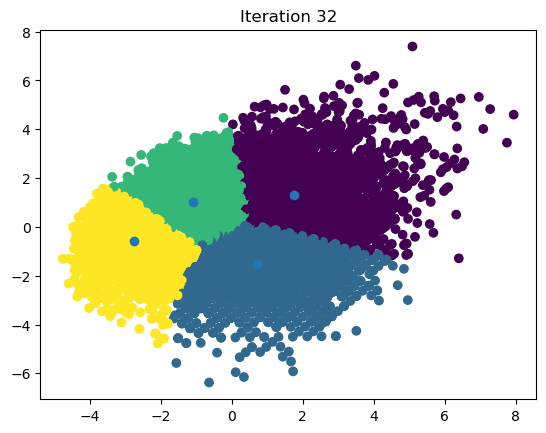

In [77]:
max_iterations = 100 # stopping criteria
k = 4 # number of clusters

centroids = random_cent(players, k) 
old_centroids = pd.DataFrame()
iteration = 1

# we will iterate until number of iterations is less than 100 AND centroids are no longer changing. To check the later
# condition we will compare previous set of centroids with the new set, and if they both are same, we will stop!
while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(players, centroids)
    centroids = new_cent(players, labels, k)
    plot_clusters(players, labels, centroids, iteration)
    iteration += 1

#### Analyzing output
Let's see the first cluster (0th column below). It consists of the best players (highest overall) and they have the most wage. 

The fourth cluster consists of the youngest players (least 'age' value)

In [78]:
 centroids

,0,1,2,3
overall,6.407184,4.651326,4.308463,2.581217
potential,6.520606,4.377841,5.836061,4.273632
wage_eur,1.615210,1.089579,1.074077,1.017245
value_eur,1.371856,1.035761,1.062697,1.013417
age,4.431376,5.439415,2.701158,2.485968


The table below proves our hypothesis that the first cluster represents the best players. MESSI!!!

In [86]:
data[labels==0][["short_name"] + features].head()

,short_name,overall,potential,wage_eur,value_eur,age
0,L. Messi,93,93,320000.0,78000000.0,34
1,R. Lewandowski,92,92,270000.0,119500000.0,32
2,Cristiano Ronaldo,91,91,270000.0,45000000.0,36
3,Neymar Jr,91,91,270000.0,129000000.0,29
4,K. De Bruyne,91,91,350000.0,125500000.0,30
